# Programming Exercise 5 - Regularized Linear Regression and Bias v.s. Variance

**Take away from the course video**:

What should you try if the model cannot predict well?
- Get more training examples                              --> fixes high variance
- Try smaller sets of features                            --> fixes high variance
- Try getting additional features                         --> fixes high bias
- Try adding polynomial features ($x_1^2, x_1x_2, etc$)     --> fixes high bias
- Try decreasing $\lambda$                                 --> fixes high bias
- Try increasing $\lambda$                                 --> fixes high variance

**Note**:    

$$Err(x)=E[(f(x)-\hat{f(x)})^2]$$    
$$Err(x)=E[(\hat{f(x)}-f(x))^2]+E[(\hat{f(x)}-E[\hat{f(x)}])^2]+\varepsilon^2$$     
$$Err(x)=Bias^2+Variance+\text{Irreducible Error}$$

# Regularized Linear Regression

In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

## Visualizing the dataset

We will begin by visualizing the dataset containing historical records on the change in the water level, x, and the amount of water flowing out of the dam, y.   

This dataset is divided into three parts:

- A training set that your model will learn on: X, y
- A cross validation set for determining the regularization parameter: Xval, yval
- A test set for evaluating performance. These are “unseen” examples which your model did not see during training: Xtest, ytest

In [1]:
%matplotlib inline

from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
data = loadmat('data/ex5data1.mat')
X, y = data['X'], data['y']
X_val, y_val = data['Xval'], data['yval']
X_test, y_test = data['Xtest'], data['ytest']

X.shape, y.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12, 1), (12, 1), (21, 1), (21, 1), (21, 1), (21, 1))

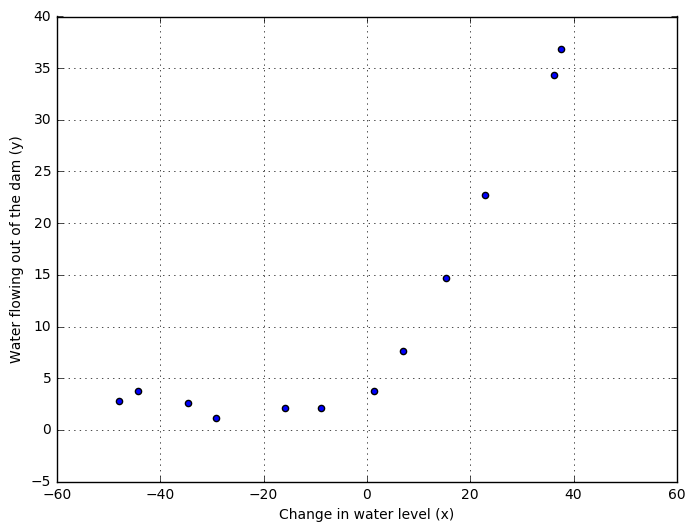

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.grid(True)
plt.show()

## Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:

$$
J(\theta)=\frac{1}{2m}\left(\sum\limits_{i=0}^m{(h(\theta)^{(i)}-y^{(i)})^2}\right)+\frac{\lambda}{2m}\sum\limits_{j=1}^n{(\theta_j)^2}
$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.

## Regularized linear regression gradient

Correspondingly, the partial derivative of the cost function for regularized linear regression is defined as:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}
$$

You should now complete the code in the function linearRegCostFunction in the next cell. Your task is to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops.

In [4]:
def linearRegCostFunction(theta, X, y, reg):
    m = X.shape[0] 
    prediction = X.dot(theta)
    cost = (1 / (2 * m)) * np.sum(np.square(prediction - y))
    penalty = (reg / (2 * m)) * np.sum(np.square(theta[1:]))
    cost = cost + penalty
    
    grad = (1 / m) * np.dot(X.T, (prediction - y))
    grad[1: ] = grad[1: ] + reg / m * theta[1: ].reshape(-1, 1)
    
    return cost, grad

When you are finished, the next cell will run your cost function and expect to see an output of 303.993.

In [5]:
test_theta = np.ones((2,1))
test_cost, test_grad = linearRegCostFunction(test_theta, np.c_[np.ones((X.shape[0], 1)), X], y, 1)
print('cost is: %.3f' % test_cost)
print('grad is: \n')
print(test_grad)

cost is: 303.993
grad is: 

[[ -15.30301567]
 [ 598.25074417]]


## Fitting linear regression

In [6]:
def gradientDescent(X, y, theta, alpha, num_iters, reg):
    
    m = X.shape[0]
    cost_history =[]
    
    for i in range(num_iters):
        cost, grad = linearRegCostFunction(theta, X, y, reg)
        theta = theta - (alpha * grad)
        cost_history.append(cost)
    
    return theta, cost_history

In [7]:
initial_theta = np.zeros((2,1))
theta_1, cost_hist_1 = gradientDescent(np.c_[np.ones((X.shape[0], 1)), X], y, initial_theta, 0.001, 4000, 0)
theta_1

array([[ 12.81756012],
       [  0.36615787]])

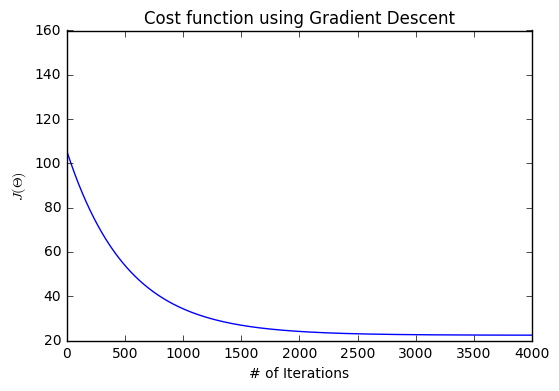

In [8]:
plt.plot(cost_hist_1)
plt.xlabel("# of Iterations")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

Finally, the code in the next cell should also plot the best fit line, which should look like the figure below.

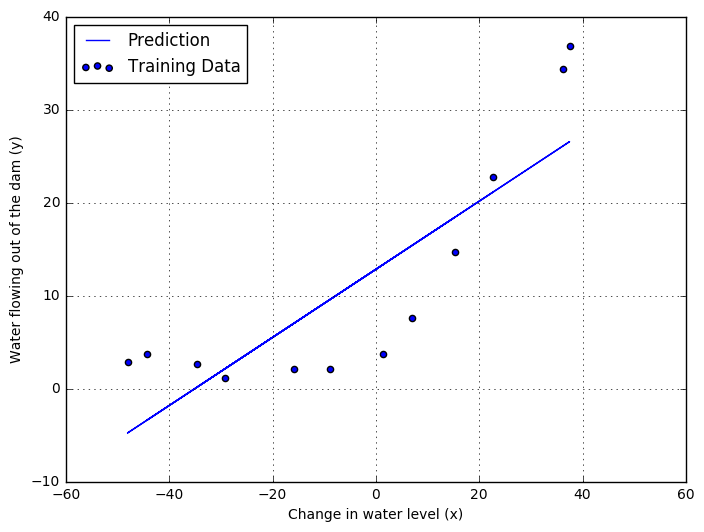

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Training Data')
plt.plot(X, (theta_1[0] + theta_1[1] * X), label='Prediction')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.legend(loc=2)
plt.grid(True)
plt.show()

The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.

# Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Mod- els with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

## Learning curves

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to fill in the function learningCurve in the next cell, so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set X. Specifically, for a training set size of $i$, you should use the first $i$ examples (i.e., X[:i, :] and y[:i]).

You can use the trainLinearReg function to find the $\theta$ parameters. Note that the lambda_ is passed as a parameter to the learningCurve function. After learning the $\theta$ parameters, you should compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as

$$ J_{\text{train}} = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2 \right] $$
In particular, note that the training error **does not include the regularization term**. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., X[:n,:] and y[:n]) instead of the entire training set. However, for the cross validation error, you should compute it over the entire cross validation set. You should store the computed errors in the vectors error train and error val.

In [10]:
def learningCurve(X, y, X_val, y_val, reg):
    m = X.shape[0]
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    for i in np.arange(1, m + 1):
        theta = gradientDescent(X[: i,:],y[:i,:], np.zeros((X.shape[1], 1)), 0.001, 3000, reg)[0]
        error_train[i - 1] = linearRegCostFunction(theta, X[: i, :], y[:i], reg)[0]
        error_val[i - 1] = linearRegCostFunction(theta, X_val, y_val, reg)[0]
        
    return error_train, error_val

In [11]:
error_train, error_val = learningCurve(np.c_[np.ones((X.shape[0], 1)), X], y, 
                                       np.c_[np.ones((X_val.shape[0], 1)), X_val], y_val, 0)

print("# Training Examples\t Train Error \t\t Cross Validation Error")
for i in range(1,13):
    print("\t",i,"\t\t", error_train[i-1], "\t" , error_val[i-1], "\n")

# Training Examples	 Train Error 		 Cross Validation Error
	 1 		 [  9.86076132e-32] 	 [ 205.12109575] 

	 2 		 [ 0.26667458] 	 [ 164.25356055] 

	 3 		 [ 3.54818564] 	 [ 45.54817577] 

	 4 		 [ 3.18748894] 	 [ 50.52763122] 

	 5 		 [ 13.54362451] 	 [ 33.88189168] 

	 6 		 [ 19.77082269] 	 [ 33.33501764] 

	 7 		 [ 20.35490054] 	 [ 32.44949026] 

	 8 		 [ 18.49136793] 	 [ 30.89743482] 

	 9 		 [ 22.86492663] 	 [ 32.09291116] 

	 10 		 [ 23.62456104] 	 [ 29.65401403] 

	 11 		 [ 24.60460849] 	 [ 30.89007392] 

	 12 		 [ 22.62043727] 	 [ 30.55405372] 



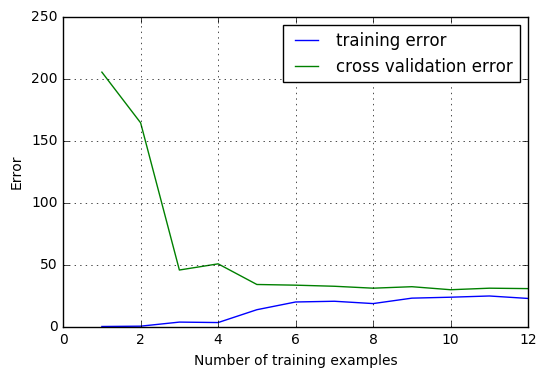

In [12]:
plt.plot(np.arange(1, X.shape[0] + 1), error_train, label='training error')
plt.plot(np.arange(1, X.shape[0] + 1), error_val, label='cross validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(loc=0)
plt.grid(True)
plt.show()

In the learning curve figure, you can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model - the linear regression model is too simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

# Polynomial regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features. For polynomial regression, our hypothesis has the form:

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ , $\cdots$, $x_p =
(\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing feature $x$ in the dataset. Your task in this part is to complete the code in the function polyFeatures in the next cell. The function should map the original training set $X$ of size $m \times 1$ into its higher powers. Specifically, when a training set $X$ of size $m \times 1$ is passed into the function, the function should return a $m \times p$ matrix X_poly, where column 1 holds the original values of X, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on. Note that you don’t have to account for the zero-eth power in this function.

In [13]:
def polyFeatures(X, p):
    
    # X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    X_poly = X
    
    for i in range(1, p):
        X_poly = np.c_[X_poly, np.power(X, i+1)]
    
    return X_poly

Now you have a function that will map features to a higher dimension. The next cell will apply it to the training set, the test set, and the cross validation set.

## Learning Polynomial Regression

After you have completed the function polyFeatures, we will proceed to train polynomial regression using your linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that you wrote for the earlier part of this exercise.

For this part of the exercise, you will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature $x_8 = 40^8 = 6.5 \times 10^{12}$). Therefore, you will need to use feature normalization.

Before learning the parameters $\theta$ for the polynomial regression, we first call featureNormalize and normalize the features of the training set, storing the mu, sigma parameters separately.

In [14]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [15]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.c_[np.ones((X_poly.shape[0], 1)), X_poly]

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(X_test, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.c_[np.ones((X_poly_test.shape[0], 1)), X_poly_test]

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(X_val, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.c_[np.ones((X_poly_val.shape[0], 1)), X_poly_val]

print('Normalized Training Example 1:')
X_poly[1, :]

Normalized Training Example 1:


array([ 1.        , -0.8389201 ,  0.0013142 , -0.25896174, -0.34156482,
        0.09754927, -0.45519664,  0.26677343, -0.46887381])

After learning the parameters $\theta$, you should see two plots generated for polynomial regression with $\lambda = 0$.

You should see that the polynomial fit is able to follow the datapoints very well, thus, obtaining a low training error. The below figure that the training error essentially stays zero for all numbers of training samples. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda = 0$) model, you can see that the learning curve shows the same effect where the training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

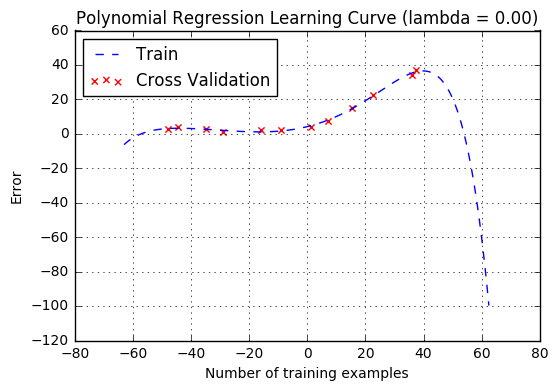

In [16]:
initial_poly_theta = np.zeros((X_poly.shape[1], 1))
reg_0 = 0

optimized_theta_reg_0 = gradientDescent(X_poly, y, initial_poly_theta, 0.3, 2000, reg_0)[0]

x_value = np.arange(np.min(X) - 15, np.max(X) + 25, 0.05).reshape(-1, 1)
# Map the X values and normalize
x_value_poly = polyFeatures(x_value, p)
x_value_poly = (x_value_poly - mu) / sigma
x_value_poly = np.c_[np.ones((x_value_poly.shape[0], 1)), x_value_poly]
y_value= np.dot(x_value_poly, optimized_theta_reg_0)

plt.scatter(X,y,marker="x",color="r")
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")
plt.plot(x_value,y_value,"--",color="b")

plt.title('Polynomial Regression Learning Curve (lambda = %.2f)' % reg_0)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'], loc=2)
plt.grid(True)
plt.show()

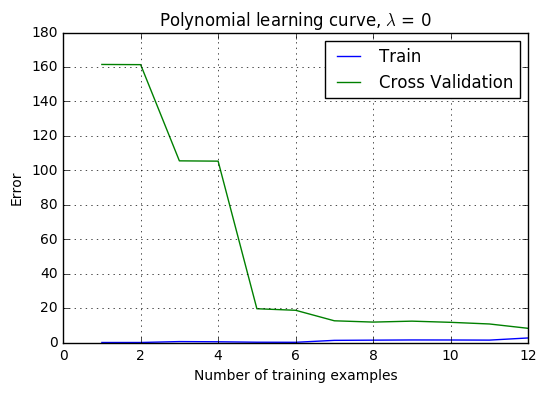

In [17]:
# Get the errors with lambda_coef set to 0.
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, reg_0)

plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Polynomial learning curve, $\lambda$ = 0')
plt.plot(range(1, X_poly.shape[0] + 1), error_train, 'b', label='Train')
plt.plot(range(1, X_poly.shape[0] + 1), error_val, 'g', label='Cross Validation')
plt.legend(loc=0)
plt.grid(True)
plt.show()

One way to combat the overfitting (high-variance) problem is to add regularization to the model. In the next section, you will get to try different $\lambda$ parameters to see how regularization can lead to a better model.

## Adjusting the regularization parameter

In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. You should now modify the the lambda parameter and try $\lambda = 1, 100$. For each of these values, the script should generate a polynomial fit to the data and also a learning curve.

For $\lambda = 1$, the generated plots should look like the the figure below. You should see a polynomial fit that follows the data trend well (left) and a learning curve (right) showing that both the cross validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

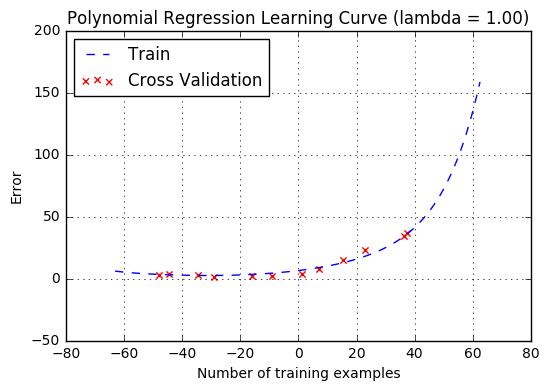

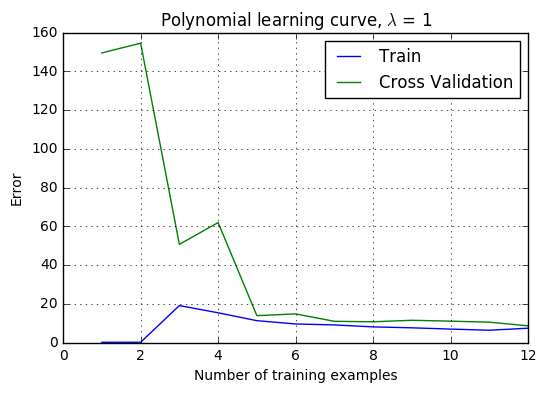

In [18]:
# λ=1

reg_1 = 1

optimized_theta_reg_0 = gradientDescent(X_poly, y, initial_poly_theta, 0.01, 2000, reg_1)[0]

x_value = np.arange(np.min(X) - 15, np.max(X) + 25, 0.05).reshape(-1, 1)
# Map the X values and normalize
x_value_poly = polyFeatures(x_value, p)
x_value_poly = (x_value_poly - mu) / sigma
x_value_poly = np.c_[np.ones((x_value_poly.shape[0], 1)), x_value_poly]
y_value= np.dot(x_value_poly, optimized_theta_reg_0)

plt.scatter(X,y,marker="x",color="r")
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")
plt.plot(x_value,y_value,"--",color="b")

plt.title('Polynomial Regression Learning Curve (lambda = %.2f)' % reg_1)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'], loc=2)
plt.grid(True)
plt.show()

# Get the errors with lambda_coef set to 1.
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, reg_1)

plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Polynomial learning curve, $\lambda$ = 1')
plt.plot(range(1, X_poly.shape[0] + 1), error_train, 'b', label='Train')
plt.plot(range(1, X_poly.shape[0] + 1), error_val, 'g', label='Cross Validation')
plt.legend(loc=0)
plt.grid(True)
plt.show()

For $\lambda = 100$, you should see a polynomial fit (figure below) that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

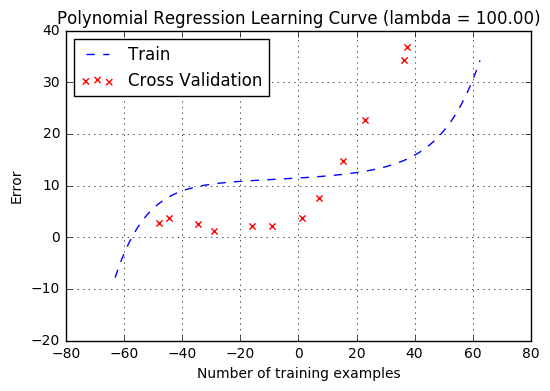

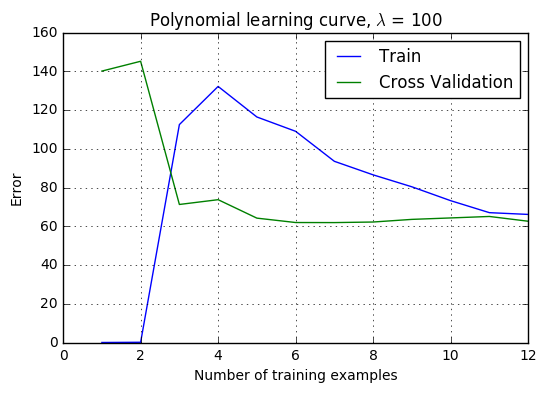

In [19]:
# λ=100

reg_100 = 100

optimized_theta_reg_0 = gradientDescent(X_poly, y, initial_poly_theta, 0.01, 2000, reg_100)[0]

x_value = np.arange(np.min(X) - 15, np.max(X) + 25, 0.05).reshape(-1, 1)
# Map the X values and normalize
x_value_poly = polyFeatures(x_value, p)
x_value_poly = (x_value_poly - mu) / sigma
x_value_poly = np.c_[np.ones((x_value_poly.shape[0], 1)), x_value_poly]
y_value= np.dot(x_value_poly, optimized_theta_reg_0)

plt.scatter(X,y,marker="x",color="r")
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")
plt.plot(x_value,y_value,"--",color="b")

plt.title('Polynomial Regression Learning Curve (lambda = %.2f)' % reg_100)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'], loc=2)
plt.grid(True)
plt.show()

# Get the errors with lambda_coef set to 1.
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, reg_100)

plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Polynomial learning curve, $\lambda$ = 100')
plt.plot(range(1, X_poly.shape[0] + 1), error_train, 'b', label='Train')
plt.plot(range(1, X_poly.shape[0] + 1), error_val, 'g', label='Cross Validation')
plt.legend(loc=0)
plt.grid(True)
plt.show()